# Overview

This tutorial demonstrates the basic capabilities of the [`AutoGP`](@ref) package.

In [1]:
import AutoGP

In [2]:
import CSV
import Dates
import DataFrames

using PyPlot: plt

## Loading Data

The first step is to load a dataset from disk. The [`tsdl.161.csv`](assets/tsdl.161.csv) file, obtained from the [Time Series Data Library](https://pkg.yangzhuoranyang.com/tsdl/), has two columns:

- `ds` indicates time stamps.
- `y` indicates measured time series values.

In the call to `CSV.File`, we explicitly set the type of the `ds` column to `Dates.Date`, permitted types for time indexes are types `T <: Real` and `T < :Dates.TimeType`, see [`AutoGP.IndexType`](@ref).

In [3]:
data = CSV.File("assets/tsdl.161.csv"; header=[:ds, :y], types=Dict(:ds=>Dates.Date, :y=>Float64));
df = DataFrames.DataFrame(data)
show(df)

     │ ds          y
─────┼───────────────────
   1 │ 1949-01-01  112.0
   2 │ 1949-02-01  118.0
   3 │ 1949-03-01  132.0
   4 │ 1949-04-01  129.0
   5 │ 1949-05-01  121.0
   6 │ 1949-06-01  135.0
   7 │ 1949-07-01  148.0
   8 │ 1949-08-01  148.0
   9 │ 1949-09-01  136.0
  10 │ 1949-10-01  119.0
  11 │ 1949-11-01  104.0
  12 │ 1949-12-01  118.0
  ⋮  │     ⋮         ⋮
 134 │ 1960-02-01  391.0
 135 │ 1960-03-01  419.0
 136 │ 1960-04-01  461.0
 137 │ 1960-05-01  472.0
 138 │ 1960-06-01  535.0
 139 │ 1960-07-01  622.0
 140 │ 1960-08-01  606.0
 141 │ 1960-09-01  508.0
 142 │ 1960-10-01  461.0
 143 │ 1960-11-01  390.0
 144 │ 1960-12-01  432.0
         121 rows omitted

We next split the data into a training set and test set.

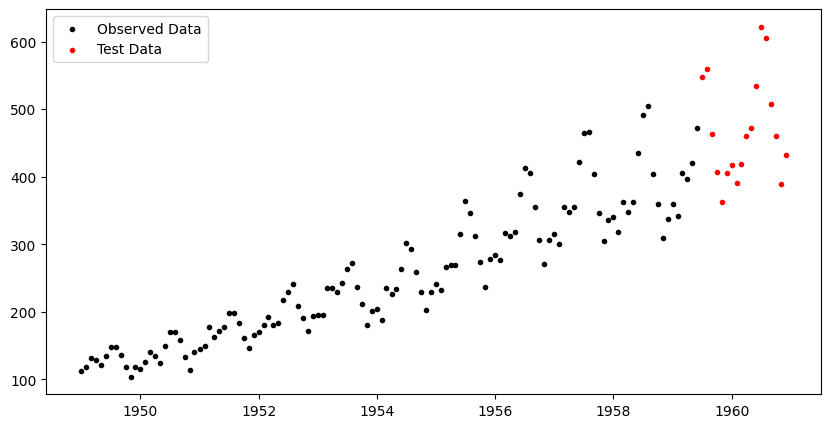

In [4]:
n_test = 18
n_train = DataFrames.nrow(df) - n_test
df_train = df[1:end-n_test, :]
df_test = df[end-n_test+1:end, :]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_train.ds, df_train.y, marker=".", color="k", label="Observed Data")
ax.scatter(df_test.ds, df_test.y, marker=".", color="r", label="Test Data")
ax.legend();

## Creating an AutoGP Model

Julia natively supports multiprocessing, which greatly improves performance for embarrassingly parallel computations in `AutoGP`. The number of threads available to Julia can be set using the `JULIA_NUM_THREADS=[nthreads]` environment variable or invoking `julia -t [nthreads]` from the command line.

In [5]:
Threads.nthreads()

20

We next initialize a [`AutoGP.GPModel`](@ref), which will enable us to automatically discover an ensemble of [Gaussian process covariance kernels](@ref gp_cov_kernel) for modeling the time series data. Initially, the model structures and parameters are sampled from the prior.  The `n_particles` argument is optional and specifices the number of particles for [sequential Monte Carlo inference](#Fitting-the-Model-using-Sequential-Monte-Carlo).

In [6]:
model = AutoGP.GPModel(df_train.ds, df_train.y; n_particles=6);

## Generating Prior Forecasts

Calling [`AutoGP.covariance_kernels`](@ref) returns the ensemble of covariance kernel structures and parameters, whose weights are given by [`AutoGP.particle_weights`](@ref). These model structures have not yet been fitted to the data, so we are essentially importance sampling the posterior over structures and parameters given data by using the prior distribution as the proposal.

In [7]:
weights = AutoGP.particle_weights(model)
kernels = AutoGP.covariance_kernels(model)
for (i, (k, w)) in enumerate(zip(kernels, weights))
    println("Model $(i), Weight $(w)")
    Base.display(k)
end

Model 1, Weight 6.296092912101311e-17


×
├── ×
│   ├── ×
│   │   ├── GE(0.11, 0.60; 0.15)
│   │   └── PER(0.06, 0.06; 0.29)
│   └── GE(0.05, 1.42; 0.21)
└── GE(0.59, 0.83; 0.04)


Model 2, Weight 2.0401974384132194e-38


GE(0.09, 0.57; 0.38)


Model 3, Weight 1.5916195805498244e-30


+
├── LIN(0.13; 0.78, 0.32)
└── GE(0.30, 0.90; 0.39)


Model 4, Weight 3.420289792517908e-27


+
├── PER(0.10, 0.04; 0.11)
└── ×
    ├── +
    │   ├── LIN(0.06; 0.36, 0.21)
    │   └── GE(0.09, 1.38; 0.05)
    └── GE(0.01, 0.53; 0.09)


Model 5, Weight 1.0


LIN(0.04; 0.08, 0.59)


Model 6, Weight 4.18427119840966e-63


LIN(0.28; 0.08, 0.19)


Forecasts are obtained using [`AutoGP.predict`](@ref), which takes in a `model`, a list of time points `ds` (which we specify to be the observed time points, the test time points, and 36 months of future time points). We also specify a list of `quantiles` for obtaining prediction intervals. The return value is a [`DataFrames.DataFrame`](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrame) object that show the particle id, particle weight, and predictions from each of the particles in `model`.

In [8]:
ds_future = range(start=df.ds[end]+Dates.Month(1), step=Dates.Month(1), length=36)
ds_query = vcat(df_train.ds, df_test.ds, ds_future)
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975])
show(forecasts)

      │ ds          particle  weight       y_0.025     y_0.975   y_mean
──────┼──────────────────────────────────────────────────────────────────
    1 │ 1949-01-01         1  6.29609e-17    -1.35226   506.787  252.718
    2 │ 1949-02-01         1  6.29609e-17    -1.33137   506.808  252.738
    3 │ 1949-03-01         1  6.29609e-17    -1.29718   506.843  252.773
    4 │ 1949-04-01         1  6.29609e-17    -1.30954   506.83   252.76
    5 │ 1949-05-01         1  6.29609e-17    -1.33588   506.804  252.734
    6 │ 1949-06-01         1  6.29609e-17    -1.28715   506.853  252.783
    7 │ 1949-07-01         1  6.29609e-17    -1.25668   506.883  252.813
    8 │ 1949-08-01         1  6.29609e-17    -1.22798   506.912  252.842
    9 │ 1949-09-01         1  6.29609e-17    -1.27006   506.87   252.8
   10 │ 1949-10-01         1  6.29609e-17    -1.34289   506.797  252.727
   11 │ 1949-11-01         1  6.29609e-17    -1.39554   506.744  252.674
   12 │ 1949-12-01         1  6.29609e-17    -1.34715 

Let us visualize the forecasts before model fitting. The model clearly underfits the data.

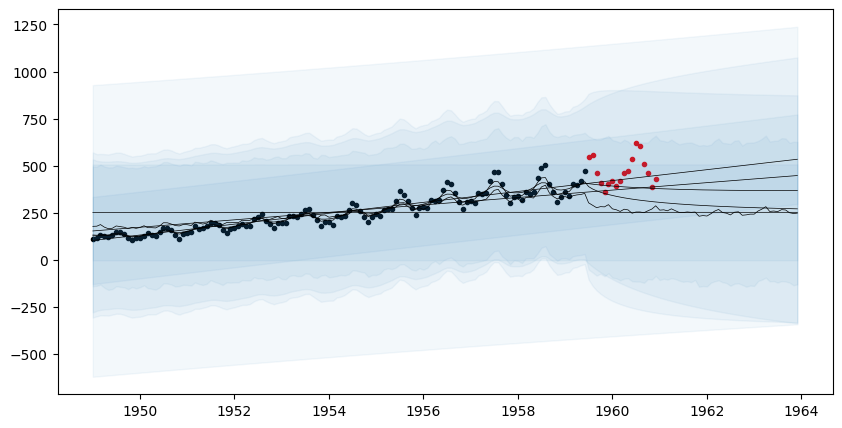

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(df_train.ds, df_train.y, marker=".", color="k", label="Observed Data")
ax.scatter(df_test.ds, df_test.y, marker=".", color="r", label="Test Data")

for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
    ax.fill_between(
        subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
        color="tab:blue", alpha=0.05)
end

## Model Fitting via SMC

The next step is to fit the model to the observed data. There are [three fitting algorithms](@ref end_to_end_model_fitting) available.  We will use [`AutoGP.fit_smc!`](@ref) which leverages sequential Monte Carlo structure learning to infer the covariance kernel structures and parameters.

The annealing schedule below adds roughly 10% of the observed data at each step, with 100 MCMC rejuvenation steps over the structure and 10 Hamiltonian Monte Carlo steps for the parameters. Using `verbose=true` will print some statistics about the acceptance rates of difference MCMC and HMC moves that are performed within the SMC learning algorithm.

In [10]:
AutoGP.seed!(6)
AutoGP.fit_smc!(model; schedule=AutoGP.Schedule.linear_schedule(n_train, .10), n_mcmc=75, n_hmc=10, verbose=true);

Running SMC round 13/126
Particle Weights: [2.14e-01, 5.85e-02, 2.05e-01, 5.23e-01, 1.09e-04, 1.51e-04]
Particle ESS: 0.4572303532503514
resampled true
accepted MCMC[10/75] HMC[74/79]
accepted MCMC[16/75] HMC[80/91]
accepted MCMC[23/75] HMC[132/147]
accepted MCMC[26/75] HMC[150/167]
accepted MCMC[26/75] HMC[157/175]
accepted MCMC[38/75] HMC[144/175]
Running SMC round 26/126
Particle Weights: [1.57e-02, 1.53e-01, 1.62e-02, 4.28e-01, 1.93e-01, 1.94e-01]
Particle ESS: 0.5914054002144326
resampled false
accepted MCMC[5/75] HMC[26/29]
accepted MCMC[6/75] HMC[39/42]
accepted MCMC[6/75] HMC[31/35]
accepted MCMC[9/75] HMC[58/63]
accepted MCMC[8/75] HMC[53/57]
accepted MCMC[19/75] HMC[89/104]
Running SMC round 39/126
Particle Weights: [4.43e-03, 5.24e-02, 3.45e-02, 6.07e-01, 5.00e-02, 2.52e-01]
Particle ESS: 0.3806180484554518
resampled true
accepted MCMC[2/75] HMC[4/6]
accepted MCMC[2/75] HMC[12/13]
accepted MCMC[5/75] HMC[26/29]
accepted MCMC[6/75] HMC[36/41]
accepted MCMC[6/75] HMC[36/40]
ac

## Generating Posterior Forecasts

Having the fit data, we can now inspect the ensemble of posterior structures, parameters, and predictions.

In [11]:
ds_future = range(start=df_test.ds[end]+Dates.Month(1), step=Dates.Month(1), length=36)
ds_query = vcat(df_train.ds, df_test.ds, ds_future)
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975]);
show(forecasts)

      │ ds          particle  weight     y_0.025   y_0.975   y_mean
──────┼──────────────────────────────────────────────────────────────
    1 │ 1949-01-01         1  0.0384436   89.6018   129.101  109.352
    2 │ 1949-02-01         1  0.0384436  102.317    140.368  121.342
    3 │ 1949-03-01         1  0.0384436  111.773    149.736  130.755
    4 │ 1949-04-01         1  0.0384436  108.746    146.754  127.75
    5 │ 1949-05-01         1  0.0384436  102.256    140.235  121.245
    6 │ 1949-06-01         1  0.0384436  110.732    148.673  129.703
    7 │ 1949-07-01         1  0.0384436  125.932    163.863  144.897
    8 │ 1949-08-01         1  0.0384436  128.77     166.73   147.75
    9 │ 1949-09-01         1  0.0384436  113.886    151.79   132.838
   10 │ 1949-10-01         1  0.0384436   96.7482   134.624  115.686
   11 │ 1949-11-01         1  0.0384436   89.6838   127.535  108.609
   12 │ 1949-12-01         1  0.0384436   95.1194   132.953  114.036
  ⋮   │     ⋮          ⋮          ⋮ 

The plot below reflects posterior uncertainty as to whether the linear componenet will persist or the data will revert to the mean.

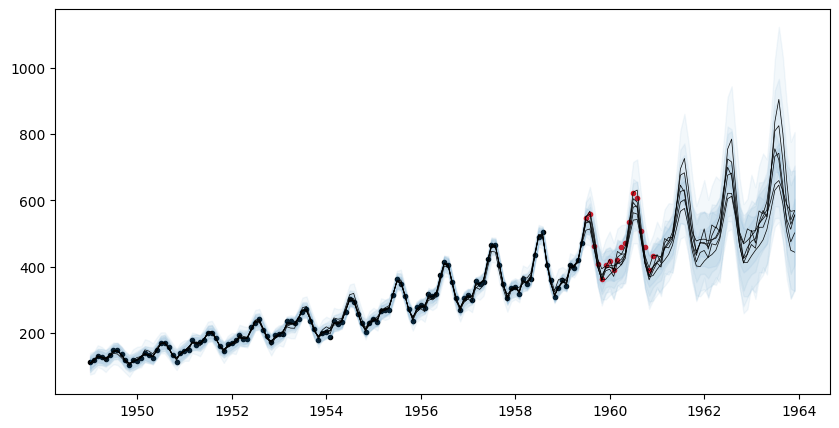

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_train.ds, df_train.y, marker=".", color="k", label="Observed Data")
ax.scatter(df_test.ds, df_test.y, marker=".", color="r", label="Test Data")

for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
    ax.fill_between(
        subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
        color="tab:blue", alpha=0.05)
end

We can also inspect the discovered kernel structures and their weights.

In [13]:
weights = AutoGP.particle_weights(model)
kernels = AutoGP.covariance_kernels(model)
for (i, (k, w)) in enumerate(zip(kernels, weights))
    println("Model $(i), Weight $(w)")
    display(k)
end

Model 1, Weight 0.03844357820185837


+
├── +
│   ├── ×
│   │   ├── ×
│   │   │   ├── LIN(0.24; 0.05, 0.59)
│   │   │   └── LIN(0.06; 0.30, 0.40)
│   │   └── GE(0.08, 0.57; 0.02)
│   └── LIN(0.16; 0.10, 0.44)
└── ×
    ├── LIN(0.26; 0.19, 0.12)
    └── PER(0.79, 0.19; 0.51)


Model 2, Weight 0.024383890262524716


×
├── +
│   ├── PER(0.53, 0.10; 0.08)
│   └── LIN(0.07; 0.70, 0.23)
└── LIN(0.19; 0.35, 0.15)


Model 3, Weight 0.11138123284136558


+
├── ×
│   ├── ×
│   │   ├── LIN(0.18; 0.25, 0.06)
│   │   └── ×
│   │       ├── +
│   │       │   ├── +
│   │       │   │   ├── ×
│   │       │   │   │   ├── ×
│   │       │   │   │   │   ├── +
│   │       │   │   │   │   │   ├── LIN(0.39; 0.14, 0.10)
│   │       │   │   │   │   │   └── GE(0.64, 0.67; 1.09)
│   │       │   │   │   │   └── GE(0.24, 0.80; 0.09)
│   │       │   │   │   └── +
│   │       │   │   │       ├── GE(0.19, 0.93; 0.13)
│   │       │   │   │       └── GE(0.05, 0.67; 0.57)
│   │       │   │   └── LIN(0.23; 0.60, 1.92)
│   │       │   └── LIN(0.36; 0.91, 0.05)
│   │       └── +
│   │           ├── LIN(0.53; 2.75, 0.06)
│   │           └── +
│   │               ├── LIN(0.17; 0.90, 0.31)
│   │               └── LIN(0.32; 2.81, 0.92)
│   └── ×
│       ├── LIN(0.11; 0.05, 0.14)
│       └── PER(0.46, 0.19; 0.05)
└── LIN(0.43; 0.10, 0.31)


Model 4, Weight 0.7658077202711391


+
├── ×
│   ├── ×
│   │   ├── LIN(0.05; 0.42, 0.06)
│   │   └── ×
│   │       ├── +
│   │       │   ├── LIN(0.23; 0.60, 1.92)
│   │       │   └── +
│   │       │       ├── LIN(0.57; 0.10, 0.74)
│   │       │       └── ×
│   │       │           ├── PER(0.54, 0.03; 0.29)
│   │       │           └── LIN(0.15; 0.16, 0.09)
│   │       └── +
│   │           ├── LIN(0.53; 2.75, 0.06)
│   │           └── GE(0.24, 1.12; 0.62)
│   └── ×
│       ├── LIN(0.11; 0.05, 0.14)
│       └── PER(0.46, 0.19; 0.05)
└── LIN(0.43; 0.10, 0.31)


Model 5, Weight 0.03657060382175122


+
├── ×
│   ├── GE(0.69, 1.77; 1.51)
│   └── ×
│       ├── LIN(0.11; 0.05, 0.14)
│       └── PER(0.46, 0.19; 0.05)
└── ×
    ├── LIN(0.05; 0.22, 0.16)
    └── +
        ├── LIN(0.04; 0.35, 1.17)
        └── LIN(0.45; 0.38, 0.16)


Model 6, Weight 0.023412974601360406


+
├── ×
│   ├── ×
│   │   ├── LIN(0.21; 0.14, 1.23)
│   │   └── ×
│   │       ├── +
│   │       │   ├── +
│   │       │   │   ├── PER(0.49, 0.74; 0.04)
│   │       │   │   └── LIN(0.15; 0.66, 2.10)
│   │       │   └── LIN(0.36; 1.05, 0.06)
│   │       └── +
│   │           ├── LIN(0.35; 2.31, 0.06)
│   │           └── PER(0.15, 1.19; 0.12)
│   └── ×
│       ├── LIN(0.12; 0.06, 0.16)
│       └── PER(0.37, 0.19; 0.05)
└── LIN(0.49; 0.10, 0.30)


## Computing Predictive Probabilities

In addition to generating forecasts, the predictive probability of new data can be computed by using [`AutoGP.predict_proba`](@ref). The table below shows that the particles in our collection are able to predict the future data with varying accuracy, illustrating the benefits of maintaining an ensemble of learned structures.

In [14]:
logps = AutoGP.predict_proba(model, df_test.ds, df_test.y);
show(logps)

   │ particle  weight     logp
───┼───────────────────────────────
 1 │        1  0.0384436  -84.504
 2 │        2  0.0243839  -74.7709
 3 │        3  0.111381   -79.8314
 4 │        4  0.765808   -80.8256
 5 │        5  0.0365706  -84.172
 6 │        6  0.023413   -81.136

It is also possible to directly access the underlying predictive distribution of new data at arbitrary time series values by using [`AutoGP.predict_mvn`](@ref), which returns an instance of [`Distributions.MixtureModel`](https://juliastats.org/Distributions.jl/stable/mixture/#Distributions.MixtureModel). The [`Distributions.MvNormal`](https://juliastats.org/Distributions.jl/stable/multivariate/#Distributions.MvNormal) object corresponding to each of the 7 particles in the mixture can be extracted using [`Distributions.components`](https://juliastats.org/Distributions.jl/stable/mixture/#Distributions.components-Tuple{AbstractMixtureModel}) and the weights extracted using [`Distributions.probs`](https://juliastats.org/Distributions.jl/stable/mixture/#Distributions.probs-Tuple{AbstractMixtureModel}).

Each `MvNormal` in the mixture has 18 dimensions corresponding to the lenght of `df_test.ds`.

In [15]:
mvn = AutoGP.predict_mvn(model, df_test.ds)

MixtureModel{Distributions.MvNormal}(K = 6)
components[1] (prior = 0.0384): FullNormal(
dim: 18
μ: [509.9915682848951, 513.9432049891342, 463.52900302265743, 398.4553642124078, 361.24942579205936, 361.74094630235606, 376.0996890877538, 387.2668029620133, 394.63192074981487, 406.25272227528905, 434.8413974504485, 489.6979379943567, 540.5721617465598, 542.4173844563397, 481.9101131777309, 408.7811430017165, 369.94574676115633, 373.23444068120835]
Σ: [465.7821950596522 270.58489272614975 … 60.594824713679955 58.23937625231841; 270.58489272614975 639.3643068503621 … 102.68088960403948 97.08781026788144; … ; 60.594824713679955 102.68088960403948 … 1453.1583033168185 1073.4856833992749; 58.23937625231841 97.08781026788144 … 1073.4856833992749 1479.9673622114287]
)

components[2] (prior = 0.0244): FullNormal(
dim: 18
μ: [542.1375437889436, 533.5918054934192, 458.21676136251904, 398.87278741382767, 361.28335780073263, 396.3821327099355, 399.5990722512584, 391.72490484577776, 446.10262374606225

Operations from the [`Distributions`](https://juliastats.org/Distributions.jl) package can now be applied to the `mvn` object.

## Incorporating New Data

Online learning is supported by using [`AutoGP.add_data!`](@ref), which lets us incorporate a new batch of observations.  Each particle's weight will be updated based on how well it predicts the new data (technically, the predictive probability it assigns to the new observations). Before adding new data, let us first look at the current particle weights.

In [16]:
AutoGP.particle_weights(model)

6-element Vector{Float64}:
 0.03844357820185837
 0.024383890262524716
 0.11138123284136558
 0.7658077202711391
 0.03657060382175122
 0.023412974601360406

Here are the forecasts and predictive probabilities of the test data under each particle in `model`.

In [17]:
using Printf: @sprintf

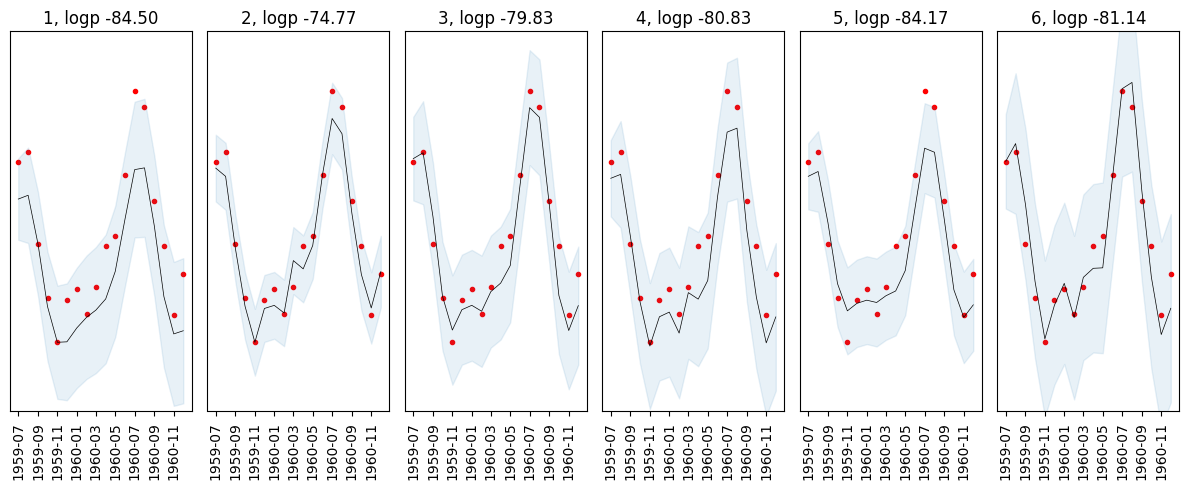

In [18]:
forecasts = AutoGP.predict(model, df_test.ds; quantiles=[0.025, 0.975])

fig, axes = plt.subplots(ncols=6)
for i=1:AutoGP.num_particles(model)
    axes[i].scatter(df_test.ds, df_test.y, marker=".", color="r", label="Test Data")
    subdf = forecasts[forecasts.particle.==i,:]
    axes[i].plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
    axes[i].fill_between(
        subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
        color="tab:blue", alpha=0.1)
    axes[i].set_title("$(i), logp $(@sprintf "%1.2f" logps[i,:logp])")
    axes[i].set_yticks([])
    axes[i].set_ylim([0.8*minimum(df_test.y), 1.1*maximum(df_test.y)])
    axes[i].tick_params(axis="x", labelrotation=90)
fig.set_size_inches(12, 5)
fig.set_tight_layout(true)
end

Now let's incorporate the data and see what happens to the particle weights.

In [19]:
AutoGP.add_data!(model, df_test.ds, df_test.y)
AutoGP.particle_weights(model)

6-element Vector{Float64}:
 8.46273833068242e-5
 0.9053490412777125
 0.02622876045200239
 0.06672963420059563
 0.00011220562538017924
 0.001495731061005186

The particle weights have changed to reflect the fact that some particles are able to predict the new data better than others, which indicates they are able to better capture the underlying data generating process.
The particles can be resampled using [`AutoGP.maybe_resample!`](@ref), we will use an effective sample size of `num_particles(model)/2` as the resampling criterion.

In [20]:
AutoGP.maybe_resample!(model, AutoGP.num_particles(model)/2)

true

Because the resampling critereon was met, the particles were resampled and now have equal weights.

In [21]:
AutoGP.particle_weights(model)

6-element Vector{Float64}:
 0.16666666666666669
 0.16666666666666669
 0.16666666666666669
 0.16666666666666669
 0.16666666666666669
 0.16666666666666669

The estimate of the marginal likelihood can be computed using [`AutoGP.log_marginal_likelihood_estimate`](@ref).

In [22]:
AutoGP.log_marginal_likelihood_estimate(model)

183.2535360377377

Since we have added new data, we can update the particle structures and parameters by using [`AutoGP.mcmc_structure!`](@ref). Note that this "particle rejuvenation" operation does not impact the weights. 

In [23]:
AutoGP.mcmc_structure!(model, 100, 10; verbose=true)

accepted MCMC[19/100] HMC[1/40]
accepted MCMC[21/100] HMC[2/45]
accepted MCMC[22/100] HMC[2/47]
accepted MCMC[22/100] HMC[1/46]
accepted MCMC[23/100] HMC[1/48]
accepted MCMC[31/100] HMC[1/63]


Let's generate and plot the forecasts over the 36 month period again now that we have observed all the data. The prediction intervals are markedly narrower and it is more likely that the linear trend will persist rather than revert.

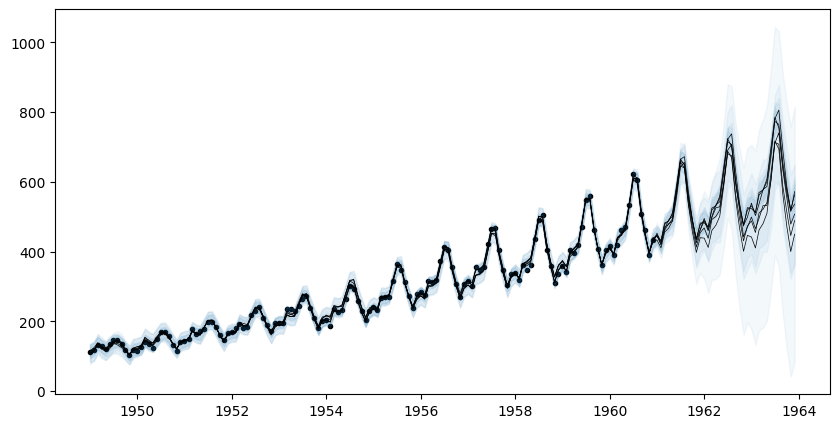

In [24]:
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975]);

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df.ds, df.y, marker=".", color="k", label="Observed Data")
for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
    ax.fill_between(
        subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
        color="tab:blue", alpha=0.05)
end

## Decomposing a Model into Constituent Parts

In [25]:
models = AutoGP.decompose(model);

In [26]:
# Helper function to pretty print covariance.
function show_string(x)
    io = IOBuffer()
    Base.show(io, MIME("text/plain"), x)
    return String(take!(io))
end

# Plot the decomposition of `model` into its constituent parts.
function plot_decomposition(model::AutoGP.GPModel)
    kernels = AutoGP.covariance_kernels(model)
    forecasts = AutoGP.predict(
        model, ds_query;
        quantiles=[0.025, 0.975]);
    fig, axes = plt.subplots(
        nrows=AutoGP.num_particles(model),
        tight_layout=true,
        figsize=(10, 6*AutoGP.num_particles(model)),
        )
    for i=1:AutoGP.num_particles(model)
        # fig, ax = plt.subplots(figsize=(10,5))
        axes[i].scatter(df.ds, df.y, marker=".", color="k", label="Observed Data")
        subdf = forecasts[forecasts.particle.==i,:]
        axes[i].plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
        axes[i].fill_between(
            subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
            color="tab:blue", alpha=0.05)
        axes[i].set_title(show_string(kernels[i]), ha="left")
    end
    return fig, axes
end

plot_decomposition (generic function with 1 method)

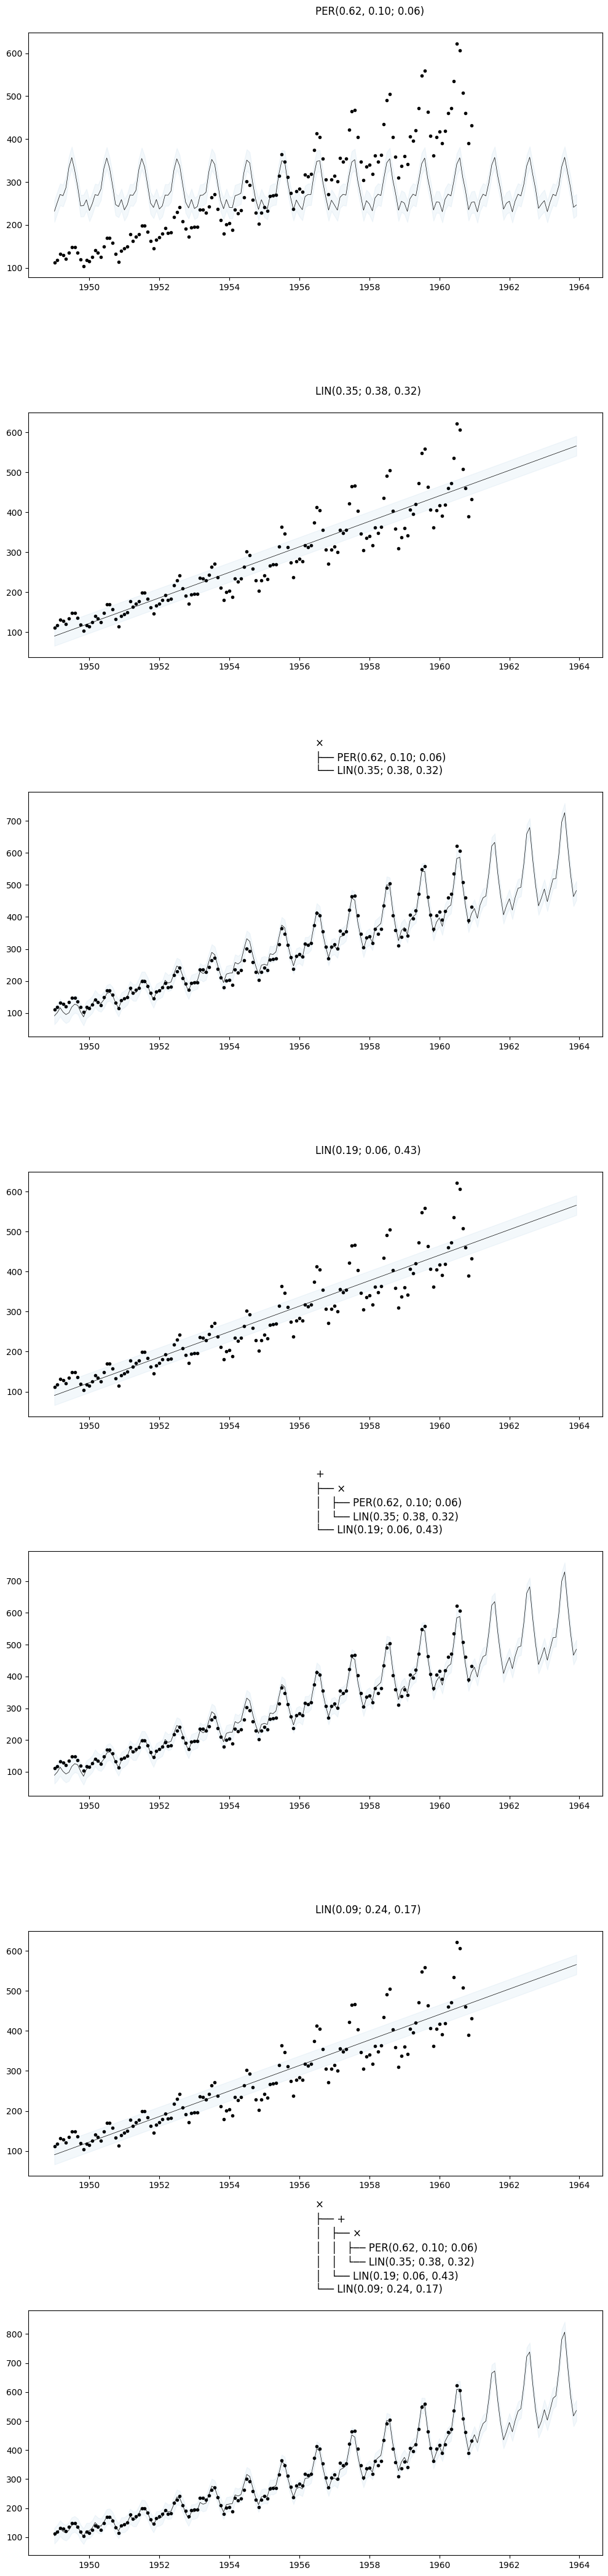

In [27]:
# Plot the kernel
fig, axes = plot_decomposition(models[1])
fig.savefig("/tmp/decomposition.pdf")